<a href="https://colab.research.google.com/github/jhubar/master-thesis/blob/main/LMV2_LARGE_bbt_star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Install dependencies

In [1]:
!rm -r transformers
!git clone https://github.com/huggingface/transformers.git
!cd tranformers
!pip install -q ./transformers 

Cloning into 'transformers'...
remote: Enumerating objects: 110141, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 110141 (delta 0), reused 4 (delta 0), pack-reused 110136
Receiving objects: 100% (110141/110141), 97.43 MiB | 36.20 MiB/s, done.
Resolving deltas: 100% (80335/80335), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!pip install -q datasets seqeval

In [3]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
!pip install sentencepiece

In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path_btt_large_qv = '/content/drive/MyDrive/LayoutLMv2/final/btt_large_star'
folder = '/content/drive/MyDrive/lr_1e5/LMV2/bttStar/'

In [7]:
train = pd.read_pickle(path_btt_large_qv+'/pickel/train.pkl')
val = pd.read_pickle(path_btt_large_qv+'/pickel/dev.pkl')
test = pd.read_pickle(path_btt_large_qv+'/pickel/test.pkl')

## Prepare the data



In [8]:
from collections import Counter

all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'Base': 9690,
         'DueDate': 17089,
         'Duedate': 6,
         'Rem': 6104,
         'RemPay': 3034,
         'TotAmount': 9253,
         'VatNr': 19098,
         'iban': 42302,
         'noise': 1587894,
         'tax': 9233})

Let's replace label noise by the "neutral" label "O" (which stands for "Outside").

In [9]:
replacing_labels = {'noise': 'O','dueDate':'O'}

In [10]:
def replace_elem(elem):
  try:
    return replacing_labels[elem]
  except KeyError:
    return elem
def replace_list(ls):
  return [replace_elem(elem) for elem in ls]


train[1] = [replace_list(ls) for ls in train[1]]
val[1] = [replace_list(ls) for ls in val[1]]
test[1] = [replace_list(ls) for ls in test[1]]


In [11]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)
labels = list(set(all_labels))
print(labels)
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)


['VatNr', 'RemPay', 'Base', 'Duedate', 'iban', 'O', 'TotAmount', 'Rem', 'tax', 'DueDate']
{'VatNr': 0, 'RemPay': 1, 'Base': 2, 'Duedate': 3, 'iban': 4, 'O': 5, 'TotAmount': 6, 'Rem': 7, 'tax': 8, 'DueDate': 9}
{0: 'VatNr', 1: 'RemPay', 2: 'Base', 3: 'Duedate', 4: 'iban', 5: 'O', 6: 'TotAmount', 7: 'Rem', 8: 'tax', 9: 'DueDate'}


Now we have to save all the unique labels in a list.

In [12]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image
class BILLYDataset(Dataset):
    """BillyDataset dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        self.words, self.labels, self.boxes = annotations
        self.image_dir = image_dir
        self.image_file_names = [f for f in listdir(image_dir)]
        self.processor = processor
        self.max_length = max_length
        

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        
        assert len(words) == len(boxes) == len(word_labels)
       
        word_labels = [label2id[label] for label in word_labels]
        encoded_inputs = processor(image, words, boxes=boxes, word_labels=word_labels,
                              padding="max_length", truncation=True, max_length=512, return_token_type_ids=True,return_tensors="pt")
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs
    


In [13]:
# from transformers import LayoutLMv2FeatureExtractor
# from transformers import LayoutXLMTokenizer
# from transformers import LayoutXLMProcessor
# from transformers import LayoutLMv2Processor


# # feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
# # tokenizer = LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base")
# # processor = LayoutXLMProcessor(feature_extractor,tokenizer)
# processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-large-uncased", apply_ocr=False)

from transformers import LayoutLMv2Processor,AutoTokenizer 


from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)  # apply_ocr is set to True by default
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlmv2-large-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

train_dataset = BILLYDataset(annotations=train,
                            image_dir= path_btt_large_qv+'/train/image/', 
                            processor=processor)
print(len(train_dataset))
val_dataset = BILLYDataset(annotations=val,
                            image_dir=path_btt_large_qv+'/dev/image/', 
                            processor=processor)
print(len(val_dataset))
test_dataset = BILLYDataset(annotations=test,
                            image_dir=path_btt_large_qv+'/test/image/', 
                            processor=processor)
print(len(test_dataset))




8252
980
1031


In [24]:
print(len(test_dataset)+len(val_dataset)+len(train_dataset))

10263


Next, we create corresponding dataloaders.

In [14]:
from torch.utils.data import DataLoader
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataloader))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(val_dataloader))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
print(len(test_dataloader))
print(len(test_dataloader)+len(test_dataloader)+len(train_dataloader))

4126
490
516
5158


## Train the model

train the model
learning rate = 1e-5 



In [15]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
 
  return results,out_label_list, preds_list

In [16]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm
from numpy import asarray
from numpy import savetxt
import numpy as np
import json
import itertools
print(torch.cuda.get_device_name(0))
model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutlmv2-large-uncased",
                                                                      num_labels=len(labels))
labels = list(set(all_labels))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cuda'
print(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)


Tesla P100-PCIE-16GB


Some weights of the model checkpoint at microsoft/layoutlmv2-large-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.9.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.12.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.8.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv2.norm.num_batches_tr

cuda:0


In [17]:


val_iterator = iter(val_dataloader)
global_step = 0
num_train_epochs = 2
train_loss = []
val_loss = []
val_precision = []
val_recall = []
val_f1 = []
preds_val = None
out_label_ids = None
batch_logits_array = []
out_label_list=[]
preds_list=[]
#put the model in training mode
val_batch_idx = 0
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   loop = tqdm(train_dataloader, leave=True)
   for batch_id, batch in enumerate(loop):
        model.train() 
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Testing part
        if val_batch_idx >= len(val_iterator):
            val_iterator = iter(val_dataloader)
            val_batch_idx = 0
        val_batch_idx += 1
        model.eval()
        with torch.no_grad():
            batch = next(val_iterator)
            input_ids = batch['input_ids'].to(device)
            bbox = batch['bbox'].to(device)
            image = batch['image'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            # forward pass
            outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                            token_type_ids=token_type_ids, labels=labels)
            if preds_val is None:
                preds_val = outputs.logits.detach().cpu().numpy()
                out_label_ids = batch["labels"].detach().cpu().numpy()
            else:
                preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0)
       

        
        loss = outputs.loss
        val_loss.append(loss.item())
         
        if global_step % 100 == 0 or global_step == 0:
            val_result,out_label_l,preds_l = results_test(preds_val, out_label_ids, list(set(all_labels)))
            val_precision.append(val_result['precision'])
            val_recall.append(val_result['recall'])
            val_f1.append(val_result['f1'])
            out_label_list.append(list(itertools.chain(*out_label_l)))
            preds_list.append(list(itertools.chain(*preds_l)))

        
            
            print("Overall results:", val_result)
            print(f"Loss after {global_step} steps: {train_loss[-1]}")
            print("Validation loss: {}".format(loss.item()))
        global_step += 1


model.save_pretrained(folder +"check_points/LargeCheckpoints_xlm_lr_1e5")
path_model = folder +'model/large_model_xlm_btt_qv_lr_star_1e5.pt'
torch.save(model, path_model)




Epoch: 0


  0%|          | 0/4126 [00:00<?, ?it/s]

Overall results: {'precision': 0.00423728813559322, 'recall': 0.058823529411764705, 'f1': 0.007905138339920948}
Loss after 0 steps: 2.5148932933807373
Validation loss: 2.0364980697631836
Overall results: {'precision': 0.39690107270560193, 'recall': 0.22981366459627328, 'f1': 0.2910839160839161}
Loss after 100 steps: 0.0840936079621315
Validation loss: 0.11576658487319946
Overall results: {'precision': 0.6176470588235294, 'recall': 0.48259052924791085, 'f1': 0.5418295543393276}
Loss after 200 steps: 0.08836435526609421
Validation loss: 0.039186980575323105
Overall results: {'precision': 0.697225891677675, 'recall': 0.6094688221709007, 'f1': 0.6504004929143562}
Loss after 300 steps: 0.07512229681015015
Validation loss: 0.06328985095024109
Overall results: {'precision': 0.7328172205438066, 'recall': 0.6739017190484459, 'f1': 0.7021257349615558}
Loss after 400 steps: 0.019884375855326653
Validation loss: 0.03515053167939186
Overall results: {'precision': 0.7578113539680211, 'recall': 0.720

  0%|          | 0/4126 [00:00<?, ?it/s]

Overall results: {'precision': 0.8963913993931286, 'recall': 0.9122105088403752, 'f1': 0.9042317724404071}
Loss after 4200 steps: 0.007939334027469158
Validation loss: 0.0041371663101017475
Overall results: {'precision': 0.8974179152056104, 'recall': 0.9130180969060129, 'f1': 0.9051507941611471}
Loss after 4300 steps: 0.024167608469724655
Validation loss: 0.004939881619066
Overall results: {'precision': 0.8982242990654206, 'recall': 0.9139696326116588, 'f1': 0.906028563797194}
Loss after 4400 steps: 0.0037834204267710447
Validation loss: 0.010584026575088501
Overall results: {'precision': 0.8991989522417154, 'recall': 0.914873177458591, 'f1': 0.9069683494235924}
Loss after 4500 steps: 0.006995456293225288
Validation loss: 0.007138874381780624
Overall results: {'precision': 0.8995888206900662, 'recall': 0.9154084045843187, 'f1': 0.9074296705938928}
Loss after 4600 steps: 0.005308070220053196
Validation loss: 0.018969647586345673
Overall results: {'precision': 0.9004258297847518, 'recall

In [18]:
# define data
data_loss = pd.DataFrame({'batch_loss_array': train_loss,'val_loss':val_loss})
data_loss.to_csv(folder + '/output/logits_btt_qv_large_star_lr_1e5.csv')
data_loss = pd.DataFrame({'precison':val_precision,'recall':val_recall,'f1':val_f1})
data_loss.to_csv(folder + '/output/metrics.csv')
data_loss = pd.DataFrame({'preds_list':preds_list,'out_label_list':out_label_list})
data_loss.to_csv(folder + '/output/classification_reports.csv')


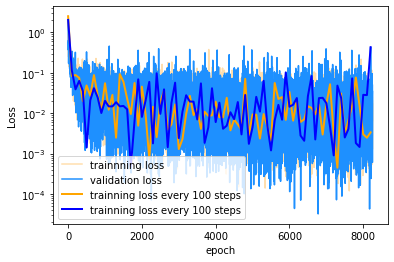

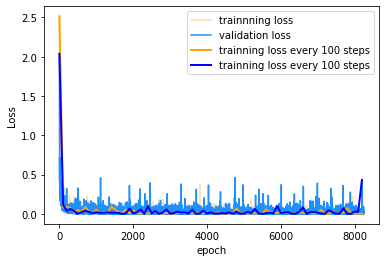

In [19]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 



x_avg_train_loss = []
y_avg_train_loss = []
x_avg_val_loss = []
y_avg_val_loss = []

x_val_precision = []
y_val_precision = []

x_avg_val_recall = []
y_avg_val_recall = []

x_avg_val_f1 = []
y_avg_val_f1 = []

for i in range(0,len(train_loss)):
   if i%100==0:
      x_avg_train_loss.append(i)
      y_avg_train_loss.append(train_loss[i]) 

for i in range(0,len(val_loss)):
   if i%100==0:
      x_avg_val_loss.append(i)
      y_avg_val_loss.append(val_loss[i]) 
      

for i in range(0,len(val_loss)):
  if i%100==0:
    try:
      x_val_precision.append(i)
      y_val_precision.append(val_precision[i])
      x_avg_val_recall.append(i)
      y_avg_val_recall.append(val_recall[i])
      x_avg_val_f1.append(i)
      y_avg_val_f1.append(val_f1[i])
    except:
      break
        

# # Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')



plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig(folder+'btt_qv_lr__star_1e5_log_test.png')
plt.legend()
plt.show()
# Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(folder+'btt_qv_star_lr_1e5_test.png')
plt.show()



## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

In [20]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)
import numpy as np

from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cuda'
print(device)
from tqdm.notebook import tqdm
from numpy import asarray
from numpy import savetxt
import numpy as np


preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
batch_test_array = []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
      
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(
              out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
          )
        


cuda:0


Evaluating:   0%|          | 0/516 [00:00<?, ?it/s]

In [21]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [22]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.934593023255814, 'recall': 0.966652999863332, 'f1': 0.9503527040644945}
              precision    recall  f1-score   support

         ase       0.91      0.95      0.93       971
        atNr       0.98      1.00      0.99      1423
          ax       0.95      0.97      0.96       941
         ban       0.98      1.00      0.99      1088
          em       0.74      0.85      0.79       546
       emPay       0.99      0.97      0.98       284
    otAmount       0.92      0.95      0.93       918
      ueDate       0.95      0.98      0.97      1146

   micro avg       0.93      0.97      0.95      7317
   macro avg       0.93      0.96      0.94      7317
weighted avg       0.94      0.97      0.95      7317



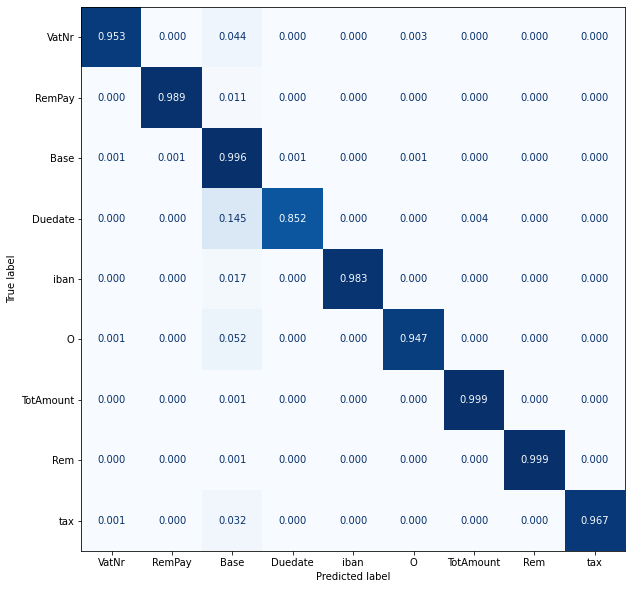

In [23]:
from matplotlib import figure
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import json
import itertools

def plot_confusion_matrix(y_preds,y_true,labels):
  cm = confusion_matrix(y_true,y_preds,normalize= "true")
  fig, ax = plt.subplots(figsize=(10,10))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
  disp.plot(cmap="Blues",values_format=".3f",ax=ax,colorbar=False)
  # plt.title("Normalized confusion matrix")
  plt.show()

def results_cm(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])


  return out_label_list,preds_list
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

# plot_confusion_matrix(preds_val, out_label_ids, labels)
# preds_val
out_label_list,preds_list =results_cm(preds_val, out_label_ids, labels)

out_label_list = list(itertools.chain(*out_label_list))
preds_list = list(itertools.chain(*preds_list))

data_conf = {'out_label_list':out_label_list,'preds_list':preds_list,'labels':labels}

with open(folder+'data_conf.json', 'w', encoding='utf-8') as f:
    json.dump(data_conf, f, ensure_ascii=False, indent=4)


plot_confusion_matrix(preds_list,out_label_list, labels)